In [1]:
#common imports
import pandas as pd
import sklearn
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import os


# Get Data

* Load the data

In [2]:
#Path to data file
HOUSING_PATH = ""

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "car.csv")
    return pd.read_csv(csv_path)
#Car Evaluation Database : http://archive.ics.uci.edu/ml/machine-learning-databases/car

* Examine the data

In [3]:
housing_full = load_housing_data()
housing_full.head()

buying  maint doors persons lug_boot safety  class
0  vhigh  vhigh     2       2    small    low  unacc
1  vhigh  vhigh     2       2    small    med  unacc
2  vhigh  vhigh     2       2    small   high  unacc
3  vhigh  vhigh     2       2      med    low  unacc
4  vhigh  vhigh     2       2      med    med  unacc

In [4]:
housing_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   class     1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [5]:
housing_full["class"].value_counts()

unacc    1210
acc       384
good       69
vgood      65
Name: class, dtype: int64

In [6]:
housing_full.describe()

buying  maint doors persons lug_boot safety  class
count    1728   1728  1728    1728     1728   1728   1728
unique      4      4     4       3        3      3      4
top     vhigh  vhigh     2       2    small    low  unacc
freq      432    432   432     576      576    576   1210

**Test set:** Now you keep aside a test set, using purely random sampling. Admittedly, this is not the best approach. In practice, we would want to use stratified sampling to ensure our test set has a representative sample of the population. For now, we won't worry about this

# Encode Data

In [8]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder(categories=[['low', 'med', 'high', 'vhigh']])
housing_full[['buying']] = enc.fit_transform(housing_full[['buying']])
housing_full[['maint']] = enc.fit_transform(housing_full[['maint']])
housing_full[['safety']] = enc.fit_transform(housing_full[['safety']])

enc = OrdinalEncoder(categories=[['2', '3', '4', '5more']])
housing_full[['doors']] = enc.fit_transform(housing_full[['doors']])

enc = OrdinalEncoder(categories=[['2', '4', 'more']])
housing_full[['persons']] = enc.fit_transform(housing_full[['persons']])

enc = OrdinalEncoder(categories=[['small', 'med', 'big']])
housing_full[['lug_boot']] = enc.fit_transform(housing_full[['lug_boot']])

enc = OrdinalEncoder(categories=[['unacc', 'acc', 'good', 'vgood']])
housing_full[['class']] = enc.fit_transform(housing_full[['class']])

housing_full[:10]

buying  maint  doors  persons  lug_boot  safety  class
0     3.0    3.0    0.0      0.0       0.0     0.0    0.0
1     3.0    3.0    0.0      0.0       0.0     1.0    0.0
2     3.0    3.0    0.0      0.0       0.0     2.0    0.0
3     3.0    3.0    0.0      0.0       1.0     0.0    0.0
4     3.0    3.0    0.0      0.0       1.0     1.0    0.0
5     3.0    3.0    0.0      0.0       1.0     2.0    0.0
6     3.0    3.0    0.0      0.0       2.0     0.0    0.0
7     3.0    3.0    0.0      0.0       2.0     1.0    0.0
8     3.0    3.0    0.0      0.0       2.0     2.0    0.0
9     3.0    3.0    0.0      1.0       0.0     0.0    0.0

In [9]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing_full, test_size=0.2, random_state=42)
print(len(housing_full),len(train_set),len(test_set))


1728 1382 346


# Visualize the data to gain insights

Make a copy of the Data

In [10]:
housing = train_set.copy()

<AxesSubplot:xlabel='class,safety'>

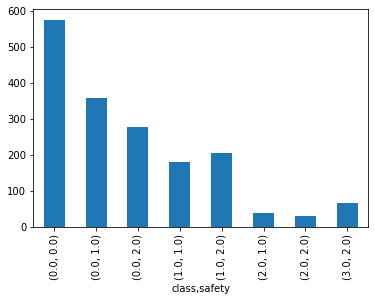

In [11]:
#housing.plot(kind="bar", x="class", y="safety")
#housing["class"].hist(figsize=(20,15))
#list(housing_full['class'].unique())
housing_full.groupby(['class','safety']).size().plot(kind="bar")

Since data is not too large, you can try computing the standard correlation coefficient between every pair of attributes. Correlation coefficient varies from 1 (strong positive correlation) to -1(strong negative correlation)

In [12]:
corr_matrix = housing.corr()

In [13]:
corr_matrix["class"].sort_values(ascending=False)

class       1.000000
safety      0.441875
persons     0.325361
lug_boot    0.164547
doors       0.077066
maint      -0.244969
buying     -0.263597
Name: class, dtype: float64

# Prepare data 

First remove the y column (target attribute) from the data

In [14]:
housing = train_set.drop("class", axis=1) # drop labels for training set, creates a copy of the data set
housing_labels = train_set["class"].copy()

So let's build a pipeline for preprocessing the numerical attributes, add median imputation and standard scaling

In [15]:
#housing_num = housing.drop("persons", axis=1)# must drop this non-numeric attribute before next steps

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer()),
        ('std_scaler', StandardScaler()),
    ])



For regression based algorithms, categorical attributes are problematic. We can map a category attribute to numbers, but a regressor might misinterpret numbers as distances between options. A better approach is to hot encode the categorical attribute. We combine the hot encoder along with the previous pipeline together. 

In [19]:
housing_prepared = num_pipeline.fit_transform(housing)
#housing.describe()
#housing[:10]

In [20]:
housing_prepared

array([[ 1.3604919 ,  1.34933099,  1.34190571,  1.22503522,  1.22474807,
         1.23546015],
       [-0.43273634,  1.34933099, -0.44385615, -0.00803009, -1.22120833,
         0.01239   ],
       [-1.32935045, -1.36241224,  1.34190571, -1.24109541,  1.22474807,
         1.23546015],
       ...,
       [ 0.46387778, -1.36241224,  1.34190571,  1.22503522,  0.00176987,
         1.23546015],
       [-1.32935045,  0.44541658,  0.44902478, -1.24109541, -1.22120833,
         0.01239   ],
       [-0.43273634, -0.45849783, -0.44385615,  1.22503522, -1.22120833,
         0.01239   ]])

In [21]:
housing_prepared.shape

(1382, 6)

# Select and train a model

Let's first try a Linear Regressor

In [90]:
from sklearn import tree

lin_reg = DecisionTreeClassifier()
lin_reg.fit(housing_prepared, housing_labels)

DecisionTreeClassifier()

In [91]:
# let's try the full preprocessing pipeline on a few training instances
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = num_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [0. 0. 0. 0. 0.]


In [81]:
print("Labels:", list(some_labels))

Labels: [0.0, 0.0, 0.0, 0.0, 0.0]


In [89]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

0.0

This implies we're more than 68K off the price of a house on average using RMSE. Maybe our model is underfitting the data. 
Let's try this for the Decision Tree version of a regressor. It uses standard deviation reduction instead of Information Gain in the ID3 algorithm

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [ ]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Now we have learnt the data too well!

Use cross validation to get a better picture of performance

In [38]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    
from sklearn.model_selection import cross_val_score
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [0.5465067  0.51365205 0.50958943 0.52049295 0.52673808 0.59563707
 0.48887185 0.52084799 0.57932655 0.56263152]
Mean: 0.5364294193194297
Standard deviation: 0.0319771815219699


In [39]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [0.29382126 0.14691063 0.14744196 0.22522131 0.12038585 0.08512565
 0.08512565 0.14744196 0.12038585 0.20851441]
Mean: 0.1580374543107835
Standard deviation: 0.06270145110304338


In [40]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

BTW, if you want to save a model, you can use the joblib library

In [41]:
import joblib
#save a model
joblib.dump(forest_reg, "forest_reg.pkl") 

#load a saved model
forest_reg = joblib.load("forest_reg.pkl") 

In [42]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

0.04504138633920422

In [43]:
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [0.20381082 0.13552456 0.09411679 0.12705984 0.09157242 0.0942745
 0.07339589 0.15003864 0.11896596 0.21705372]
Mean: 0.13058131357708652
Standard deviation: 0.045639994823939295


# Fine Tune the model

In [68]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

C:\Users\Nick\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Nick\miniconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Nick\miniconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 442, in fit
    trees = Parallel(
  File "C:\Users\Nick\miniconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "C:\Users\Nick\miniconda3\lib\site-packages\jo

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

The best feature combination found:

In [69]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [70]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30, random_state=42)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [75]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.3026769381951082 {'max_features': 2, 'n_estimators': 3}
0.23515802964496751 {'max_features': 2, 'n_estimators': 10}
0.21044801459615328 {'max_features': 2, 'n_estimators': 30}
0.1942031848811166 {'max_features': 4, 'n_estimators': 3}
0.17282382383716902 {'max_features': 4, 'n_estimators': 10}
0.1577751347152 {'max_features': 4, 'n_estimators': 30}
0.17410376306585085 {'max_features': 6, 'n_estimators': 3}
0.15675364468543676 {'max_features': 6, 'n_estimators': 10}
0.14603088783367618 {'max_features': 6, 'n_estimators': 30}
nan {'max_features': 8, 'n_estimators': 3}
nan {'max_features': 8, 'n_estimators': 10}
nan {'max_features': 8, 'n_estimators': 30}
0.2525085316369443 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
0.1932419133746785 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
0.2070434352428378 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
0.1668261153257175 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
0.17934154796825735 {'bo

Another way to search the hyperparameter space, when it is very large is to use a Randomized Search, instead of a Grid Search. 
We can also combine the best models into a combined ensemble model.

# Run on test set
It seems that Random Forests are performing best so let's test this on our test set.

In [76]:
final_model = grid_search.best_estimator_

X_test = test_set.drop("class", axis=1)
y_test = test_set["class"].copy()

# call transform, not fit_transform - you do not want to fit the test set by incorporating its values into the median, etc!
X_test_prepared = num_pipeline.transform(X_test) 
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [77]:
final_rmse

0.17368646405821497

In [78]:
joblib.dump(final_model, "final_model.pkl") 

['final_model.pkl']